# PCA

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [ ]:
# upload the data
data = np.load('/content/drive/MyDrive/Colab Notebooks/Data Files/data.npy', mmap_mode='r')
print(data.shape)
X = data[:,:-1]
print(X.shape)
target = data[:,-1]
print(target.shape)

(500, 501)
(500, 500)
(500,)


# PCA from scratch 

In [ ]:
def PCA(X , num_components):
     
    #Step-1
    X_meaned = X - np.mean(X, axis = 0)
    
    #Step-2
    cov_mat = np.cov(X_meaned, rowvar = False)
     
    #Step-3
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
     
    #Step-4
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
    #Step-5
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]
    #Step-6
    X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()
     
    return X_reduced, sorted_eigenvalue

In [ ]:
#Applying it to PCA function
mat_reduced, sorted_eigenvalue = PCA(X , 2)

#Creating a Pandas DataFrame of reduced Dataset
principal_df = pd.DataFrame(mat_reduced,columns = ['PC1','PC2'])
 
#Concat it with target variable to create a complete Dataset
principal_df = pd.concat([principal_df , pd.DataFrame(target)] , axis = 1)

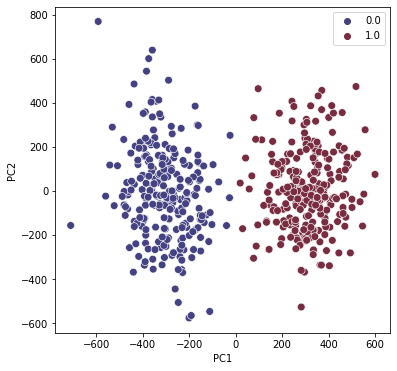

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt
 
plt.figure(figsize = (6,6))
sb.scatterplot(data = principal_df , x = 'PC1',y = 'PC2' , hue = target , s = 60 , palette= 'icefire')

In [ ]:
tot = sum(sorted_eigenvalue)
var_exp = [(i / tot)*100 for i in sorted_eigenvalue]
print(var_exp)
cum_var_exp = np.cumsum(var_exp)
print(np.round(cum_var_exp[50:200],decimals=2))

[7.31768736865101, 2.662606437640105, 2.634676346899846, 2.4125965292015596, 2.3526312808508476, 2.2574176399157553, 2.1317158882848988, 2.0777224188574914, 2.0161799345101796, 1.9339922204911641, 1.8393889636459813, 1.7857991647153202, 1.7675186416425799, 1.6831237336035494, 1.5865670530347713, 1.5578824831720657, 1.5182538234075058, 1.4656685226062318, 1.4412270179307054, 1.400126099942327, 1.3824169656788234, 1.3425874667156499, 1.3221567464089325, 1.2755536309753954, 1.2324172299037124, 1.2108260818951233, 1.1765818860064443, 1.158594007601038, 1.1340100371844213, 1.0949639059663778, 1.0643547272388718, 1.0452143640922547, 1.0290999853071259, 1.00015047409568, 0.9626294599005489, 0.9508593918041377, 0.920568489776297, 0.8796685796474614, 0.8642589058890746, 0.8512545733439523, 0.8351960874365094, 0.812899998479965, 0.8024133786406974, 0.7885317269831466, 0.7700653993363608, 0.7255055935628821, 0.7173711053533401, 0.6944504967079692, 0.6808326878297623, 0.6724295588254566, 0.6461980

# By projecting down to 50D, we lost about 26% of the variance:

In [ ]:
print(100-cum_var_exp[50])

26.113157458712564


# using sklearn

In [ ]:
from sklearn.decomposition import PCA
# make objects from pca and LogisticRegression models
pca = PCA()
logistic = LogisticRegression(max_iter=10000, tol=0.1)

In [ ]:
# Define a pipeline to search for the best combination of PCA truncation and classifier regularization.
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

param_grid = {
    'pca__n_components': [50,100,150,200],
    'logistic__C': np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)

In [ ]:
search.fit(X, target)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=1.000):
{'logistic__C': 0.0001, 'pca__n_components': 50}


In [ ]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

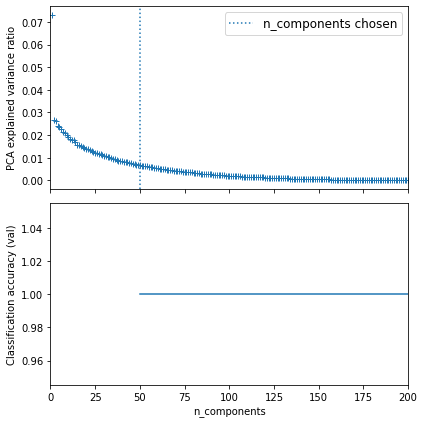

In [ ]:
# Plot the PCA spectrum
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(0, 200)

plt.tight_layout()
plt.show()

## so the best n_components is 50

# By projecting down to 50D, we lost about 26% of the variance:

In [ ]:
pca = PCA(n_components = 50)
X50D = pca.fit_transform(X)
1 - pca.explained_variance_ratio_.sum()

0.26759355488408676

# ---------------------------------------------------------------------------------------------------------------------------------------------

# LDA

In [ ]:
class LDA_C:
    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_discriminants = None
        self.mean_overall = None
        self.Len_class_labels = None

    def fit(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)
        self.Len_class_labels = len(class_labels)

        # Within class scatter matrix:
        # SW = sum((X_c - mean_X_c)^2 )

        # Between class scatter:
        # SB = sum( n_c * (mean_X_c - mean_overall)^2 )

        self.mean_overall = np.mean(X, axis=0)
        SW = np.zeros((n_features, n_features))
        SB = np.zeros((n_features, n_features))
        for c in class_labels:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            # (4, n_c) * (n_c, 4) = (4,4) -> transpose
            SW += (X_c - mean_c).T.dot((X_c - mean_c))

            # (4, 1) * (1, 4) = (4,4) -> reshape
            n_c = X_c.shape[0]
            mean_diff = (mean_c - self.mean_overall).reshape(n_features, 1)
            SB += n_c * (mean_diff).dot(mean_diff.T)

        # Determine SW^-1 * SB
        A = np.linalg.inv(SW).dot(SB)
        # Get eigenvalues and eigenvectors of SW^-1 * SB
        eigenvalues, eigenvectors = np.linalg.eig(A)
        # -> eigenvector v = [:,i] column vector, transpose for easier calculations
        # sort eigenvalues high to low
        eigenvectors = eigenvectors.T
        idxs = np.argsort(abs(eigenvalues))[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]
        # store first n eigenvectors
        self.linear_discriminants = eigenvectors[0:self.n_components]

    def transform(self, X):
        # project data
        return np.dot(X, self.linear_discriminants.T)

    def prediction(self , X):
      # in linear --> y(x) = W.T * X + W0 -->  so we need to calculate the bais (w0) 
        w0 = np.zeros((self.Len_class_labels))
        tot = 0
        for c in self.mean_overall:
            tot += np.dot(self.linear_discriminants, c)
            w0 = 0.5 * tot
        
        #print(w0.shape) # (2,2)
        w0 = w0.reshape(-1,1)
        #print(self.linear_discriminants.shape) #(2,2)
        #print(X.shape)
        X=X.reshape(30,2)
        #print(X.shape) #(30,2)

        Y = np.zeros((len(X), self.Len_class_labels))
        predict = np.zeros((len(X)), dtype=int)
        for j in range(len(X)):
          for i in range(self.Len_class_labels-1):
            Y[j, i] = np.dot(self.linear_discriminants[i].T,  X[j]) + w0[i]
          predict[j] = np.argmin(Y[j])
        return predict 
     

    
        


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris 

data = load_iris()
X, y = data.data, data.target
X_train, X_test, Y_train, Y_test = train_test_split(X[:,:2], y, test_size=0.2)

In [ ]:
obj_LDA =LDA_C(2)
obj_LDA.fit(X_train,Y_train)
X_train=obj_LDA.transform(X_train)

In [ ]:
X_test = obj_LDA.transform(X_test)

In [ ]:
obj_LDA.prediction(X_test)

array([0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       0, 0, 2, 0, 0, 0, 0, 0])

In [ ]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=5, random_state=0)

classifier.fit(X_train, Y_train)
y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(Y_test, y_pred)
print(cm)
print('Accuracy   ' + str(accuracy_score(Y_test, y_pred)))

[[13  0  0]
 [ 1  6  3]
 [ 0  1  6]]
Accuracy   0.8333333333333334


# Resources of LDA

1.   https://github.com/goelhardik/projects/blob/master/fishers_lda/lda.py
2.   https://www.kaggle.com/ma7555/fisher-s-linear-discriminant-from-scratch-85-98
3. https://machinelearningmastery.com/linear-discriminant-analysis-with-python/
4. https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html


